<div style="text-align: center">
    <img src="public/banner.png" width="600" alt="Banner" style="border-radius: 8px">
    <h1><strong>A study of Poles' psychedelic and non-psychedelic mystical experiences in relation to fear of death, emotional empathy, and life satisfaction</strong></h1>
</div>
<div style="text-align: center">
    <h3><strong>Part II: Lingustic analysis</strong></h1>
</div>

# **Table of contents**

1. [Brief introduction](#1.-brief-introduction)
2. [Imports](#2.-imports)
    1. [Importing libraries](#2.1.-importing-libraries)
    2. [Loading dataset](#2.2.-loading-dataset)
3. [Data wrangling and cleaning](#3.-data-wrangling-and-cleaning)
    1. [Joining female and male variables into one dataframe](#3.1.-joining-female-and-male-variables-into-one-dataframe)
    2. [Recoding MEQ30 scorings](#3.2.-recoding-MEQ30-scorings**)
    3. [Summing the results and checking for complete mystical experiences](#3.3.-summing-the-results-and-checking-for-complete-mystical-experiences)
    4. [Removing incomplete records from the dataset](#3.4.-removing-incomplete-records-from-the-dataset)
    5. [Filtering records that include description of an experience](#3.5.-filtering-records-that-include-description-of-an-experience)
4. [Translation](#4.-translation)
    1. [Using DeepL REST API](#.4.1.-using-deepl-rest-api)
5. [Data analysis](#5.-data-analysis)
    1. [Word frequency distribution analysis](#5.1.-word-frequency-distribution-analysis)
    2. [Correlation analysis](#5.2.-correlation-analysis)
    3. [Emotional sentiment NLP analysis](#5.3.-emotional-sentiment-nlp-analysis)
    4. [Participants' subjective assessment of the influence](#5.4.-participants'-subjective-assessment-of-the-influence)
6. [Conclusions](#6.-conclusions)
<br>
<br>
<hr>

# **1. Brief introduction**

# **2. Imports**

## **2.1. Importing libraries**

In [387]:
import pandas as pd
import numpy as np
import requests
import warnings
import re
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import STOPWORDS, WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from collections import Counter
from scipy.stats import pearsonr, fisher_exact
from PIL import Image, ImageDraw
from transformers import pipeline
from IPython.display import display, HTML

## **2.2. Loading dataset**

In [2]:
dataset_path = "public/dataset.xlsx"
df = pd.read_excel(dataset_path)

# **3. Data wrangling and cleaning**

## **3.1. Joining female and male variables into one dataframe**

In [3]:
columns_to_process = [col[:-2] for col in df.columns if col.endswith("_M")]
combined_columns = {}

for col in columns_to_process:
    male_col = f"{col}_M"
    female_col = f"{col}_F"
    
    if df[male_col].dtype == "float64" and df[female_col].dtype == "float64":
        male_variables = pd.to_numeric(df[male_col], errors="coerce").fillna(0)
        female_variables = pd.to_numeric(df[female_col], errors="coerce").fillna(0)
        
        combined_columns[col] = male_variables + female_variables
        
    elif df[male_col].dtype == "object" and df[female_col].dtype == "object":
        male_variables = df[male_col].fillna("")
        female_variables = df[female_col].fillna("")
        
        combined_columns[col] = male_variables + female_variables

combined_df = pd.DataFrame(combined_columns)

df = pd.concat([df, combined_df], axis=1)

df.drop(columns=[f"{col}_M" for col in columns_to_process] + [f"{col}_F" for col in columns_to_process], inplace=True)

pd.set_option("display.max_columns", None)
df.head()

,start_date,end_date,progress_in_percent,duration_in_seconds,finished,recorded_date,age,sex,survey_version,worldview,education,meditation,compound_never,compound_LSD,compound_psylocybin,compound_ayahuasca,compound_DMT,compound_5MeODMT,compound_mescaline,compound_ibogaine,compound_salvia,compound_other,compound_text,use_amount,microdose,low_dose,average_dose,high_dose,very_high_dose,mystical_experience,context_psychedelic,context_other_psychoactive,context_NDE,context_meditation,context_ritual,context_hypnosis,context_other,context_other_psychoactive_text,context_other_text,trigger_compound,order,intensity,how_long_ago,MEQ30_1,MEQ30_2,MEQ30_3,MEQ30_4,MEQ30_5,MEQ30_6,MEQ30_7,MEQ30_8,MEQ30_9,MEQ30_10,MEQ30_11,MEQ30_12,MEQ30_13,MEQ30_14,MEQ30_15,MEQ30_16,MEQ30_17,MEQ30_18,MEQ30_19,MEQ30_20,MEQ30_21,MEQ30_22,MEQ30_23,MEQ30_24,MEQ30_25,MEQ30_26,MEQ30_27,MEQ30_28,MEQ30_29,MEQ30_30,PES_1,PES_2,PES_3,PES_4,PES_5,PES_6,PES_7,PES_8,PES_9,PES_10,PES_11,SWLS_1,SWLS_2,SWLS_3,SWLS_4,SWLS_5,DAP_R_1,DAP_R_2,DAP_R_3,DAP_R_4,DAP_R_5,DAP_R_6,DAP_R_7,DAP_R_8,influence_empathy,influence_satisfaction,influence_fear,description_text
0,2023-02-17 22:50:49,2023-02-17 23:04:08,100,798,1,2023-02-17 23:04:09,28.0,1.0,1.0,2.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,6.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,,,2.0,0.0,0.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,6.0,5.0,5.0,5.0,4.0,6.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,2.0,5.0,2.0,4.0,3.0,3.0,4.0,4.0,2.0,3.0,4.0,2.0,1.0,3.0,5.0,6.0,7.0,5.0,6.0,7.0,7.0,5.0,2.0,2.0,2.0,
1,2023-02-18 00:24:48,2023-02-18 00:34:16,100,567,1,2023-02-18 00:34:18,30.0,1.0,1.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,2.0,5.0,3.0,2.0,2.0,3.0,4.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,3.0,1.0,2.0,3.0,1.0,4.0,4.0,2.0,0.0,0.0,0.0,
2,2023-02-18 12:57:58,2023-02-18 13:13:33,100,934,1,2023-02-18 13:13:33,25.0,2.0,2.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Haszysz,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Ciastko z haszyszem,,0.0,0.0,0.0,52.0,6.0,4.0,6.0,5.0,6.0,4.0,6.0,4.0,6.0,6.0,6.0,3.0,6.0,5.0,5.0,5.0,3.0,4.0,6.0,4.0,5.0,6.0,1.0,3.0,2.0,5.0,1.0,5.0,6.0,1.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,1.0,5.0,2.0,2.0,2.0,1.0,3.0,3.0,4.0,
3,2023-02-18 13:14:33,2023-02-18 13:18:33,100,239,1,2023-02-18 13:18:34,22.0,2.0,2.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,0.0,0.0,0.0,
4,2023-02-18 13:19:13,2023-02-18 13:26:12,100,419,1,2023-02-18 13:26:13,28.0,2.0,2.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,4.0,5.0,5.0,6.0,5.0,3.0,2.0,2.0,5.0,2.0,3.0,2.0,2.0,0.0,0.0,0.0,


## **3.2. Recoding MEQ30 scorings**

In [4]:
meq30_columns = [col for col in df.columns if col.startswith("MEQ30")]

replacement_mapping = {
    1: 0, 
    2: 1, 
    3: 2, 
    4: 3, 
    5: 4, 
    6: 5
}

df[meq30_columns] = df[meq30_columns].replace(replacement_mapping)

## **3.3. Summing the results and checking for complete mystical experiences**

In [5]:
MEQ30_subscales = {
    "Mystical": [4, 5, 6, 9, 14, 15, 16, 18, 20, 21, 23, 24, 25, 26, 28],
    "Positive Mood": [2, 8, 12, 17, 27, 30],
    "Transcendence": [1, 7, 11, 13, 19, 22],
    "Ineffability": [3, 10, 29]
}

for subscale, items in MEQ30_subscales.items():
    df.loc[:, subscale] = df[[f"MEQ30_{item}" for item in items]].sum(axis=1)
    
max_score = {
    "Mystical": len(MEQ30_subscales["Mystical"]) * 5,
    "Positive Mood": len(MEQ30_subscales["Positive Mood"]) * 5,
    "Transcendence": len(MEQ30_subscales["Transcendence"]) * 5,
    "Ineffability": len(MEQ30_subscales["Ineffability"]) * 5
}

df["MEQ_complete"] = (
    (df["Mystical"] / max_score["Mystical"] >= 0.6) &
    (df["Positive Mood"] / max_score["Positive Mood"] >= 0.6) &
    (df["Transcendence"] / max_score["Transcendence"] >= 0.6) &
    (df["Ineffability"] / max_score["Ineffability"] >= 0.6)
).astype(int)

df["MEQ_total_score"] = (
    df["Mystical"] +
    df["Positive Mood"] +
    df["Transcendence"] +
    df["Ineffability"]
)

df.iloc[:10, -6:]

,Mystical,Positive Mood,Transcendence,Ineffability,MEQ_complete,MEQ_total_score
0,60.0,23.0,27.0,15.0,1,125.0
1,0.0,0.0,0.0,0.0,0,0.0
2,50.0,10.0,30.0,15.0,0,105.0
3,0.0,0.0,0.0,0.0,0,0.0
4,0.0,0.0,0.0,0.0,0,0.0
5,15.0,14.0,6.0,3.0,0,38.0
6,62.0,26.0,27.0,13.0,1,128.0
7,0.0,0.0,0.0,0.0,0,0.0
8,0.0,0.0,0.0,0.0,0,0.0
9,0.0,0.0,0.0,0.0,0,0.0


## **3.4. Removing incomplete records from the dataset**

In [6]:
incomplete_survey = df[df["finished"] == 0]

df.drop(incomplete_survey.index, inplace=True)
df.reset_index(drop=True, inplace= True)

print(f"We are left with {df.shape[0]} completed surveys.")

We are left with 724 completed surveys.


## **3.5. Filtering records that include description of an experience**

In [7]:
df_desc = df[df["description_text"] != ""]
df_desc.reset_index(drop=True, inplace= True)

print(f"Out of these {df.shape[0]} records, {df_desc.shape[0]} participants decided to share a description of their experience.")

Out of these 724 records, 338 participants decided to share a description of their experience.


# **4. Translation**

## **4.1. Using DeepL REST API**

In [8]:
# def translate(description, target_lang="EN-US", api_key="API_KEY_PLACEHOLDER"):
#     url = "https://api.deepl.com/v2/translate"
#     params = {
#         "auth_key": api_key,
#         "text": description,
#         "target_lang": target_lang
#     }
#     response = requests.post(url, data=params)
#     result = response.json()
#     return result["translations"][0]["text"]

In [9]:
# polish_descriptions = df_desc["description_text"]

# english_descriptions = []

# for description in polish_descriptions:
#     try:
#         translated_description = translate(description)
#         english_descriptions.append(translated_description)
#     except Exception as e:
#         print(f"Error translating text: {description}, error: {e}")
#         english_descriptions.append(None)

# df_translated = df_desc.copy()
# df_translated["description_text_EN"] = english_descriptions

In [10]:
# df_translated.to_excel("public/dataset_with_english_descriptions.xlsx", index=False)

In [11]:
translated_dataset_path = "public/dataset_with_english_descriptions.xlsx"
df_english = pd.read_excel(translated_dataset_path)

pd.set_option("display.max_colwidth", 1000)
df_english[["description_text", "description_text_EN", "MEQ_total_score", "MEQ_complete"]].head(5)

,description_text,description_text_EN,MEQ_total_score,MEQ_complete
0,"Po ponad 72 godzinach bez snu w trakcie których zażywałem duże ilości mdma, psylocybiny oraz thc - gdy sen w końcu nadszedł, byłem podczas tego praktycznie sto procent świadomy - to ja decydowałem co będzie się działo dalej, podejmując decyzję wynikające z wewnętrznego dialogu. W pewnym momencie poczułem niesamowita błogość i ciepło i zobaczyłem siebie leżącego na łóżku obok mojej partnerki - widziałem siebie, z zaciekawieniem się sobie przyglądałem. To trwało jakieś 5 może 10 minut, podczas których płakałem i cieszyłem się jednocześnie. Zmieniło to moje życie w takim sensie, że zastanawiałem się a co jeśli będąc w takim stanie spotkam kogoś kto też w nim jest? Co się stanie? Czy będziemy mogli się porozumieć?","After more than 72 hours without sleep during which I took large amounts of mdma, psilocybin and thc - when sleep finally came, I was practically one hundred percent conscious during it - I was the one who decided what was going to happen next, making decisions resulting from the internal dialogue. At one point, I felt incredible bliss and warmth and saw myself lying on the bed next to my partner - I could see myself, curiously looking at myself. This went on for about 5 maybe 10 minutes, during which I cried and rejoiced at the same time. It changed my life in the sense that I wondered what if, being in this state, I meet someone who is also in it? What will happen? Will we be able to communicate?",119,1
1,Wyleczyło mnie z dolegliwości które lekarze bezskutecznie leczyli od 15 lat,It cured me of ailments that doctors had been treating for 15 years without success,130,1
2,"Doświadczenie miało miejsce 7 lat temu. Podczas jazdy małym busem bez świateł w środku słuchałam jakiegoś powolnego utworu. Zamknęłam oczy i położyłam głowę na oparciu. Podróż mogła trwać max 20 minut - dla mnie trwała pare godzin. Czułam jakbym ja była w muzyce, nie potrafie tego opisać. Wiedziałam, ze po otwarciu oczu mogłabym wcale już nie być w busie, było błogo, czułam się bezpiecznie, że unoszę się w powietrzu, a nie jestem w swoim ciele, byłam gdzieś daleko. Do teraz nie wiem jak to opisać, ani co to było. To doświadczenie na pewno zostanie ze mną do końca życia jako niesamowite i niewyjaśnione uniesienie.","The experience took place 7 years ago. While driving a small bus with no lights inside, I was listening to some slow song. I closed my eyes and laid my head on the backrest. The trip may have lasted 20 minutes max - for me it lasted a couple of hours. I felt like I was in the music, I can't describe it. I knew that after opening my eyes I might not be in the bus at all anymore, it was blissful, I felt safe, that I was floating in the air, not in my body, I was somewhere far away. To this day I don't know how to describe it or what it was. This experience will definitely stay with me for the rest of my life as an amazing and unexplained rapture.",92,0
3,"Wrazenie podrzymywania mnie jako osoby,które bylo we mnie ale nie ze mnie",Along with holding me up as a person that was in me but not of me,77,0
4,"jak to jest, że coś tak materialnego jak umysł może dać początek czemuś tak niematerialnemu jak doświadczenie?",How is it that something as material as the mind can give rise to something as immaterial as experience?,64,0


# **5. Data analysis**

## **5.1. Word frequency distribution analysis**

In [12]:
concatenated_descriptions = " ".join(df_english["description_text_EN"])

In [13]:
stopwords = set(STOPWORDS).union({"ve"})

tokens = word_tokenize(concatenated_descriptions.lower())

filtered_tokens = [
    word for word in tokens if 
    word.isalpha() and word not in stopwords
]

In [14]:
word_frequencies = Counter(filtered_tokens)
top_25_words = word_frequencies.most_common(25)

top_25_words

[('experience', 244),
 ('life', 168),
 ('felt', 135),
 ('time', 117),
 ('body', 80),
 ('everything', 75),
 ('one', 74),
 ('something', 66),
 ('feeling', 64),
 ('experienced', 64),
 ('experiences', 61),
 ('feel', 58),
 ('love', 57),
 ('world', 56),
 ('sense', 53),
 ('know', 50),
 ('state', 48),
 ('death', 48),
 ('saw', 43),
 ('first', 42),
 ('trip', 41),
 ('reality', 41),
 ('people', 40),
 ('able', 38),
 ('many', 38)]

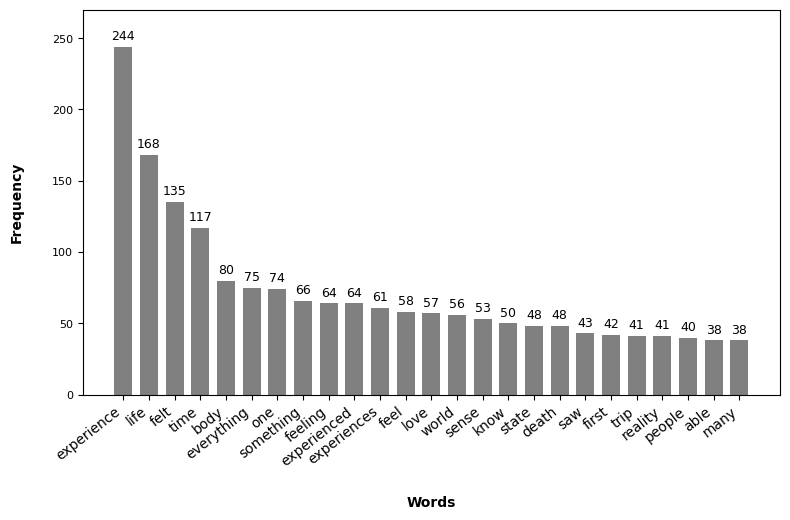

In [388]:
words, frequencies = zip(*top_25_words)

plt.figure(figsize=(9, 5))
plt.xlabel("Words", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Frequency", fontweight="bold", fontsize=10, labelpad=20)
plt.xticks(rotation=38, ha="right", fontsize=10)
plt.yticks(fontsize=8)
plt.ylim(0, 270)

bars = plt.bar(words, frequencies, color="grey", width=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha="center", fontsize=9)

figure1_html = """
<p style="font-size: 14px">
    <strong>Figure 1.</strong> Frequency distribution of the 25 most common words used in the analyzed descriptions (<i>N</i> = 338) excluding predefined stopwords.
</p>
"""
display(HTML(figure1_html))

plt.show()

## **5.2. Correlation analysis**

In [16]:
warnings.filterwarnings("ignore")

unique_tokens = set()
for text in df_english["description_text_EN"]:
    tokens = re.findall(r"\d\w*", text)
    unique_tokens.update(tokens)

numeric_starting_tokens = list(unique_tokens)

stopwords_list = list(stopwords)
stopwords_list.extend(numeric_starting_tokens)
    
vectorizer = CountVectorizer(stop_words=stopwords_list)
X = vectorizer.fit_transform(df_english["description_text_EN"])

word_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

df_combined = pd.concat([df_english[["MEQ_total_score"]], word_features], axis=1)

df_combined.head(10)

MEQ_total_score  abandoned  abilities  ability  able  absence  absolute  \
0              119          0          0        0     1        0         0   
1              130          0          0        0     0        0         0   
2               92          0          0        0     0        0         0   
3               77          0          0        0     0        0         0   
4               64          0          0        0     0        0         0   
5               26          0          0        0     0        0         0   
6               94          0          0        0     1        0         0   
7              116          0          0        0     0        0         0   
8               74          0          0        0     0        0         0   
9              114          0          0        0     0        0         0   

   absolutely  absorbing  abstract  abundance  abuse  abusing  abusive  abyss  \
0           0          0         0          0      0        0        0      0   
1           0          0         0          0      0        0        0      0   
2           0          0         0          0      0        0        0      0   
3           0          0         0          0      0        0        0      0   
4           0          0         0          0      0        0        0      0   
5           0          0         0          0      0        0        0      0   
6           0          0         0          0      0        0        0      0   
7           0          0         0          0      0        0        0      0   
8           0          0         0          0      0        0        0      0   
9           0          0         0          0      0        0        0      0   

   accent  accept  acceptance  accepted  accepting  access  accident  \
0       0       0           0         0          0       0         0   
1       0       0           0         0          0       0         0   
2       0       0           0         0          0       0         0   
3       0       0           0         0          0       0         0   
4       0       0           0         0          0       0         0   
5       0       0           0         0          0       0         0   
6       0       0           0         0          0       0         0   
7       0       0           0         0          0       0         0   
8       0       0           0         0          0       0         0   
9       0       0           0         0          0       0         0   

   accompanied  accompany  accompanying  accomplishment  acct  acha  achieve  \
0            0          0             0               0     0     0        0   
1            0          0             0               0     0     0        0   
2            0          0             0               0     0     0        0   
3            0          0             0               0     0     0        0   
4            0          0             0               0     0     0        0   
5            0          0             0               0     0     0        0   
6            0          0             0               0     0     0        0   
7            0          0             0               0     0     0        0   
8            0          0             0               0     0     0        0   
9            0          0             0               0     0     0        0   

   achieved  achieving  acid  acquainted  across  act  action  actions  \
0         0          0     0           0       0    0       0        0   
1         0          0     0           0       0    0       0        0   
2         0          0     0           0       0    0       0        0   
3         0          0     0           0       0    0       0        0   
4         0          0     0           0       0    0       0        0   
5         0          0     1           0       0    0       0        0   
6         0          0     0           0       0    0       

In [17]:
correlation_results = []

for col in word_features.columns:
    feature_data = df_combined[col]
    corr, p_value = pearsonr(df_combined["MEQ_total_score"].loc[feature_data.index], feature_data)
    
    if p_value < 0.05:
         correlation_results.append((col, f"{corr:.2f}", f"{p_value:.3f}"))

results_df = pd.DataFrame(correlation_results, columns=["Token", "Pearson's r", "p-value"])
results_df["Pearson's r"] = results_df["Pearson's r"].astype(float)

positive_R = results_df[results_df.apply(lambda x: x ["Pearson's r"] > 0, axis=1)]
negative_R = results_df[results_df.apply(lambda x: x ["Pearson's r"] < 0, axis=1)]

sorted_positive_R = positive_R.sort_values(by="Pearson's r", ascending=False)
sorted_negative_R = negative_R.sort_values(by="Pearson's r", ascending=True)

print(f"We've got {sorted_positive_R.shape[0]} words positively, and {sorted_negative_R.shape[0]} words negatively correlated with the MEQ30 scores.")

We've got 29 words positively, and 166 words negatively correlated with the MEQ30 scores.


In [18]:
sorted_positive_R.head(10)

,Token,Pearson's r,p-value
190,world,0.15,0.007
82,infinite,0.15,0.007
4,always,0.14,0.012
41,died,0.14,0.008
49,energy,0.14,0.012
76,heaven,0.13,0.018
161,stage,0.13,0.020
94,let,0.13,0.016
80,huge,0.13,0.018
192,years,0.13,0.019


In [19]:
sorted_negative_R.head(10)

,Token,Pearson's r,p-value
60,frightened,-0.21,0.000
53,example,-0.20,0.000
25,communion,-0.20,0.000
55,facts,-0.19,0.000
20,call,-0.19,0.001
12,bad,-0.18,0.001
139,recommend,-0.17,0.002
167,tachycardia,-0.17,0.002
127,pleasant,-0.17,0.001
181,unrealness,-0.17,0.002


### **5.2.1. Visualizing the correlations as word clouds**

In [20]:
width, height = 800, 500
ellipse_width = width * 0.85
ellipse_height = height * 0.9

mask = Image.new("L", (width, height), 255)
draw = ImageDraw.Draw(mask)

draw.ellipse(
    [(width // 2 - ellipse_width // 2, height // 2 - ellipse_height // 2),
     (width // 2 + ellipse_width // 2, height // 2 + ellipse_height // 2)],
    fill=0
)

mask.save("public/ellipse_mask.png")

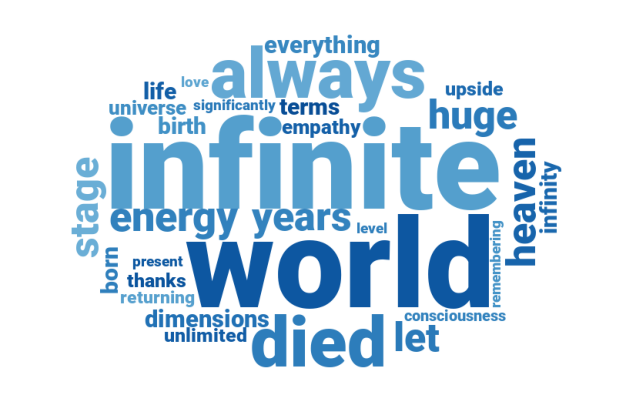

In [136]:
word_frequencies = dict(zip(sorted_positive_R["Token"], sorted_positive_R["Pearson's r"]))

blues = plt.cm.get_cmap("Blues")
start = 0.5
end = 0.9
edited_blues = LinearSegmentedColormap.from_list("new_blues", blues(np.linspace(start, end, 256)))

roboto_font = "public/fonts/Roboto/Roboto-Black.ttf"
mask_image = np.array(Image.open("public/ellipse_mask.png"))

wordcloud = WordCloud(
    width=800, 
    height=600,
    background_color="white",
    colormap=edited_blues,
    font_path=roboto_font,
    mask=mask_image
).generate_from_frequencies(word_frequencies)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud)
plt.axis("off")

figure2_html = """
<p style="font-size: 14px">
    <strong>Figure 2.</strong> Word cloud illustrating 29 words that are positively correlated with MEQ30 scores.
    Larger words represent stronger correlations, with correlation coefficient (<i>r</i>) ranging from 0.11 to 0.15 
    and <i>p</i>-values less than 0.05 for each word. The hue of the words was randomly assigned to enhance readability.
</p>
"""
display(HTML(figure2_html))

plt.show()

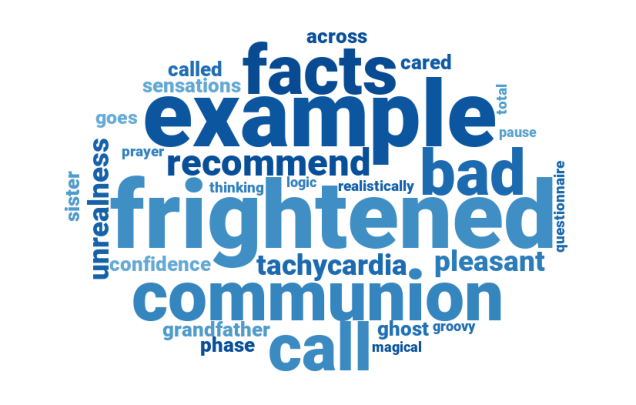

In [135]:
absolute_negative_R_values = sorted_negative_R["Pearson's r"].abs()

word_frequencies = dict(zip(sorted_negative_R["Token"], absolute_negative_R_values))
limited_word_frequencies = dict(list(word_frequencies.items())[:29])

blues = plt.cm.get_cmap("Blues")
start = 0.5
end = 0.9
edited_blues = LinearSegmentedColormap.from_list("new_blues", blues(np.linspace(start, end, 256)))

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color="white",
    colormap=edited_blues,
    font_path=roboto_font,
    mask=mask_image
).generate_from_frequencies(limited_word_frequencies)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud)
plt.axis("off")

figure3_html = """
<p style="font-size: 14px">
    <strong>Figure 3.</strong> Word cloud illustrating top 29 words that are negatively correlated with MEQ30 scores.
    Larger words represent stronger correlations, with correlation coefficient (<i>r</i>) ranging from -0.14 to -0.21 
    and <i>p</i>-values less than 0.05 for each word. The hue of the words was randomly assigned to enhance readability.
</p>
"""
display(HTML(figure3_html))

plt.show()

## **5.3. Emotional sentiment NLP analysis**

### **5.3.1. Complete mystical experiences**

In [23]:
model_name = "arpanghoshal/EmoRoBERTa"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

filtered_df_complete = df_english[df_english["MEQ_complete"] == 1]
descriptions_complete = filtered_df_complete["description_text_EN"].tolist()
sentiment_results_complete = []

batch_size = 32

for i in range(0, len(descriptions_complete), batch_size):
    batch = descriptions_complete[i:i + batch_size]
    results = sentiment_pipeline(batch)
    sentiment_results_complete.extend(results)

total_results = len(sentiment_results_complete)
print(f"\nNumber of chunks analyzed: {total_results}\n")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.



Number of chunks analyzed: 152



In [24]:
unique_labels = set(result["label"] for result in sentiment_results_complete)
label_counts = {label: 0 for label in unique_labels}

for result in sentiment_results_complete:
    label_counts[result["label"]] += result["score"]

emotion_data_complete = [(label, label_counts[label]) for label in unique_labels]
total_score_complete = sum(label_counts.values())
percentage_data_complete = [(label, (score / total_score_complete) * 100) for label, score in emotion_data_complete]

print("Aggregated emotion analysis results:\n")
for emotion, score in percentage_data_complete:
    print(f"{emotion.capitalize()}: {score:.2f}%")

Aggregated emotion analysis results:

Surprise: 3.15%
Amusement: 0.32%
Love: 6.12%
Excitement: 1.17%
Desire: 0.55%
Admiration: 15.49%
Sadness: 2.93%
Joy: 9.48%
Neutral: 9.85%
Caring: 1.49%
Realization: 23.90%
Grief: 0.43%
Fear: 4.34%
Gratitude: 5.57%
Approval: 10.13%
Confusion: 1.11%
Disappointment: 0.70%
Nervousness: 0.40%
Relief: 1.36%
Embarrassment: 0.53%
Optimism: 0.98%


### **5.3.2. Non-complete mystical experiences**

In [25]:
model_name = "arpanghoshal/EmoRoBERTa"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

filtered_df_non_complete = df_english[df_english["MEQ_complete"] == 0]
descriptions_non_complete = filtered_df_non_complete["description_text_EN"].tolist()
sentiment_results_non_complete = []

batch_size = 32

for i in range(0, len(descriptions_non_complete), batch_size):
    batch = descriptions_non_complete[i:i + batch_size]
    results = sentiment_pipeline(batch)
    sentiment_results_non_complete.extend(results)

total_results = len(sentiment_results_non_complete)
print(f"\nNumber of chunks analyzed: {total_results}\n")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.



Number of chunks analyzed: 186



In [26]:
unique_labels = set(result["label"] for result in sentiment_results_non_complete)
label_counts = {label: 0 for label in unique_labels}

for result in sentiment_results_non_complete:
    label_counts[result["label"]] += result["score"]

emotion_data_non_complete = [(label, label_counts[label]) for label in unique_labels]
total_score_non_complete = sum(label_counts.values())
percentage_data_non_complete = [(label, (score / total_score_non_complete) * 100) for label, score in emotion_data_non_complete]

print("Aggregated emotion analysis results:\n")
for emotion, score in percentage_data_non_complete:
    print(f"{emotion.capitalize()}: {score:.2f}%")

Aggregated emotion analysis results:

Surprise: 6.90%
Amusement: 0.43%
Love: 4.46%
Excitement: 0.34%
Admiration: 3.98%
Sadness: 3.06%
Joy: 9.52%
Neutral: 8.25%
Caring: 0.88%
Realization: 31.49%
Grief: 0.52%
Fear: 13.31%
Gratitude: 4.29%
Approval: 7.24%
Curiosity: 1.06%
Disappointment: 1.14%
Nervousness: 1.05%
Relief: 0.76%
Optimism: 1.33%


### **5.3.3. Bar plots for both groups**

In [382]:
emotion_names_complete = [emotion[0].capitalize() for emotion in percentage_data_complete]
emotion_names_non_complete = [emotion[0].capitalize() for emotion in percentage_data_non_complete]

emotion_scores_complete = [emotion[1] for emotion in emotion_data_complete]
emotion_scores_non_complete = [emotion[1] for emotion in emotion_data_non_complete]

percentage_labels_complete = [emotion[1] for emotion in percentage_data_complete]
percentage_labels_non_complete = [emotion[1] for emotion in percentage_data_non_complete]


In [383]:
all_emotions = sorted(set(emotion_names_complete + emotion_names_non_complete))

complete_percentages_dict = dict(zip(emotion_names_complete, percentage_labels_complete))
non_complete_percentages_dict = dict(zip(emotion_names_non_complete, percentage_labels_non_complete))

sorted_complete_percentages = [complete_percentages_dict.get(emotion, 0) for emotion in all_emotions]
sorted_non_complete_percentages = [non_complete_percentages_dict.get(emotion, 0) for emotion in all_emotions]

complete_scores_dict = dict(zip(emotion_names_complete, emotion_scores_complete))
for emotion in all_emotions:
    if emotion not in complete_scores_dict:
        complete_scores_dict[emotion] = 0
        
non_complete_scores_dict = dict(zip(emotion_names_non_complete, emotion_scores_non_complete))
for emotion in all_emotions:
    if emotion not in non_complete_scores_dict:
        non_complete_scores_dict[emotion] = 0


In [384]:
fisher_results = []

for emotion in all_emotions:
    observed = [
        [
            complete_scores_dict[emotion], 
            non_complete_scores_dict[emotion]
        ],
        [
            total_score_complete - complete_scores_dict[emotion], 
            total_score_non_complete - non_complete_scores_dict[emotion]
        ]
    ]
    
    oddsratio, p_value = fisher_exact(observed)
    
    fisher_results.append({
        "Emotion": emotion,
        "Odds ratio": f"{oddsratio:.2f}",
        "p-value": f"{p_value:.3f}"
    })

fisher_results_df = pd.DataFrame(fisher_results)

fisher_results_df

,Emotion,Odds ratio,p-value
0,Admiration,4.98,0.001
1,Amusement,nan,1.000
2,Approval,1.50,0.381
3,Caring,1.22,1.000
4,Confusion,inf,0.451
5,Curiosity,0.00,1.000
6,Desire,nan,1.000
7,Disappointment,0.00,1.000
8,Embarrassment,nan,1.000
9,Excitement,inf,0.451


In [385]:
p_value_dict = {row["Emotion"]: float(row["p-value"]) for _, row in fisher_results_df.iterrows()}

sum_percentages = {emotion: complete + non_complete 
                   for emotion, complete, non_complete 
                   in zip(all_emotions, sorted_complete_percentages, sorted_non_complete_percentages)}

sorted_emotions = sorted(sum_percentages.items(), key=lambda x: x[1], reverse=True)
top_n = 10
top_emotions = sorted_emotions[:top_n]
sorted_emotion_names = [emotion for emotion, _ in top_emotions]
sorted_complete_scores = [sorted_complete_percentages[all_emotions.index(emotion)] for emotion in sorted_emotion_names]
sorted_non_complete_scores = [sorted_non_complete_percentages[all_emotions.index(emotion)] for emotion in sorted_emotion_names]


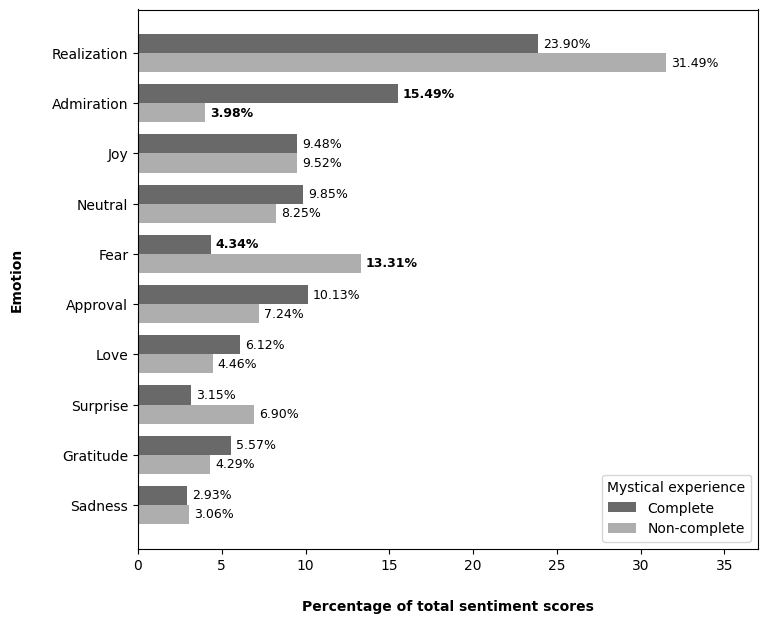

In [386]:
bar_width = 0.38
index = np.arange(len(sorted_emotion_names))
plt.figure(figsize=(8, 7))

bars_complete = plt.barh(index - bar_width / 2, sorted_complete_scores, bar_width, label="Complete", color="#696969")
bars_non_complete = plt.barh(index + bar_width / 2, sorted_non_complete_scores, bar_width, label="Non-complete", color="#AEAEAE")

def add_labels(bars, emotion_names, scores):
    for bar, emotion, score in zip(bars, emotion_names, scores):
        width = bar.get_width()
        p_value = p_value_dict.get(emotion, 1)
        weight = "bold" if p_value < 0.05 else "normal"
        plt.text(
            width + 0.3,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}%",
            va="center",
            fontsize=9,
            fontweight=weight
        )

add_labels(bars_complete, sorted_emotion_names, sorted_complete_scores)
add_labels(bars_non_complete, sorted_emotion_names, sorted_non_complete_scores)

plt.xlabel("Percentage of total sentiment scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Emotion", fontweight="bold", fontsize=10, labelpad=20)
plt.yticks(index, sorted_emotion_names, fontsize=10)
plt.xticks(fontsize=10)
plt.legend(title="Mystical experience")
plt.xlim(0, 37)
plt.gca().invert_yaxis()

figure4_html = """
<p style="font-size: 14px">
    <strong>Figure 4.</strong> Horizontal bar plot comparing the proportions of the top 10 emotions in descriptions provided by 
    participants who experienced a complete mystical experience (<i>N</i> = 152) and those who did not (<i>N</i> = 186).
    Statistically significant differences (<i>p</i> < 0.05) are highlited in bold.
</p>
"""
display(HTML(figure4_html))

plt.show()

In [390]:
positive_emotions = [
    "realization", "admiration", "caring", "joy", 
    "love", "relief", "desire", "excitement", 
    "pride", "approval", "optimism", "gratitude", "amusement"
]
neutral_emotions =[
    "neutral", "surprise"
]
negative_emotions = [
    "grief", "confusion", "fear", "annoyance", 
    "sadness", "nervousness", "remorse", "disappointment"
]


In [400]:
positive_score_complete = sum(
    score for emotion, score in emotion_data_complete 
    if emotion in positive_emotions
)
neutral_score_complete = sum(
    score for emotion, score in emotion_data_complete 
    if emotion in neutral_emotions
)
negative_score_complete = sum(
    score for emotion, score in emotion_data_complete 
    if emotion in negative_emotions
)

positive_score_non_complete = sum(
    score for emotion, score in emotion_data_non_complete 
    if emotion in positive_emotions
)
neutral_score_non_complete = sum(
    score for emotion, score in emotion_data_non_complete 
    if emotion in neutral_emotions
)
negative_score_non_complete = sum(
    score for emotion, score in emotion_data_non_complete 
    if emotion in negative_emotions
)


In [401]:
categories = ["Positive", "Neutral", "Negative"]
scores_complete = [positive_score_complete, neutral_score_complete, negative_score_complete]
scores_non_complete = [positive_score_non_complete, neutral_score_non_complete, negative_score_non_complete]

scores_complete_dict = dict(zip(categories, scores_complete))
scores_non_complete_dict = dict(zip(categories, scores_non_complete))


In [402]:
fisher_results = []
p_values = {}

for category in categories:
    observed = [
        [
            scores_complete_dict[category], 
            scores_non_complete_dict[category]
        ],
        [
            total_score_complete - scores_complete_dict[category], 
            total_score_non_complete - scores_non_complete_dict[category]
        ]
    ]
    
    oddsratio, p_value = fisher_exact(observed)
    p_values[category] = p_value
    
    fisher_results.append({
        "Category": category,
        "Odds ratio": f"{oddsratio:.2f}",
        "p-value": f"{p_value:.3f}"
    })

fisher_results_df = pd.DataFrame(fisher_results)

fisher_results_df

,Category,Odds ratio,p-value
0,Positive,1.76,0.044
1,Neutral,0.81,0.596
2,Negative,0.46,0.039


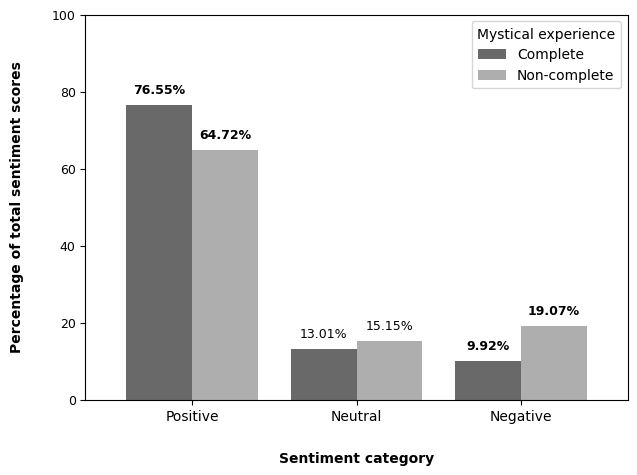

In [403]:
fisher_results_df["p-value"] = pd.to_numeric(fisher_results_df["p-value"])
significant_categories = fisher_results_df[fisher_results_df["p-value"] < 0.05]["Category"].tolist()

percentages_complete = [score / total_score_complete * 100 for score in scores_complete]
percentages_non_complete = [score / total_score_non_complete * 100 for score in scores_non_complete]

df_percentages = pd.DataFrame({
    "Complete": percentages_complete,
    "Non-complete": percentages_non_complete,
})

fig, ax = plt.subplots(figsize=(7, 5))
bars = df_percentages.plot(kind="bar", ax=ax, width=0.8, color=["#696969", "#AEAEAE"])

for container in bars.containers:
    for bar in container:
        category = categories[container.index(bar)]
        label = f"{bar.get_height():.2f}%"
        label_style = {"fontweight": "bold"} if category in significant_categories else {"fontweight": "normal"}
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 3,
            label,
            ha="center",
            fontweight=label_style["fontweight"],
            fontsize=9
        )

plt.xlabel("Sentiment category", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Percentage of total sentiment scores", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=9)
plt.ylim(0, 100)
plt.xticks(fontsize=10)
ax.set_xticklabels(categories, rotation=0)

figure5_html = """
<p style="font-size: 14px">
    <strong>Figure 5.</strong> Bar plot comparing the proportions of positive, negative, and neutral sentiments 
    between participants who experienced a complete mystical experience (<i>N</i> = 152) and those who did not (<i>N</i> = 186).
    Fisher's exact test was used to assess statistical significance, and no differences between the groups were found to be significant, 
    although statistical trends were observed for positive and negative sentiment with <i>p</i>-values of 0.085 and 0.065, respectively.
</p>
"""
display(HTML(figure5_html))

plt.show()

## **5.4. Participants' subjective assessment of the influence**

In [313]:
influence_columns = [col for col in df.columns if col.startswith("influence")]

replacement_mapping = {
    1: "Definitely positive",
    2: "Rather positive",
    3: "No influence",
    4: "Rather negative",
    5: "Definitely negative"   
}

df[influence_columns] = df[influence_columns].replace(replacement_mapping)

### **5.4.1. Fear of death**

In [396]:
filtered_df_complete = df[df["MEQ_complete"] == 1]
filtered_df_non_complete = df[df["MEQ_complete"] == 0]

index = ["Definitely negative", "Rather negative", "No influence", "Rather positive", "Definitely positive"]

complete_counts = (filtered_df_complete["influence_fear"].value_counts()).reindex(index, fill_value=0)
non_complete_counts = (filtered_df_non_complete["influence_fear"].value_counts().reindex(index, fill_value=0))

total_complete = complete_counts.sum()
total_non_complete = non_complete_counts.sum()

complete_percentages = ((complete_counts / total_complete) * 100).reindex(index, fill_value=0)
non_complete_percentages = ((non_complete_counts / total_non_complete) * 100).reindex(index, fill_value=0)

In [397]:
fisher_results = []

for category in index:
    observed = [
        [
            complete_counts[category], 
            non_complete_counts[category]
        ],
        [
            total_complete - complete_counts[category],
            total_non_complete - non_complete_counts[category]
        ]
    ]
    
    oddsratio, p_value = fisher_exact(observed)
    
    fisher_results.append({
        "Category": category,
        "Odds ratio": f"{oddsratio:.2f}",
        "p-value": f"{p_value:.3f}"
    })

fisher_results_df = pd.DataFrame(fisher_results)

fisher_results_df

,Category,Odds ratio,p-value
0,Definitely negative,0.00,0.017
1,Rather negative,0.10,0.008
2,No influence,0.32,0.000
3,Rather positive,1.35,0.123
4,Definitely positive,3.37,0.000


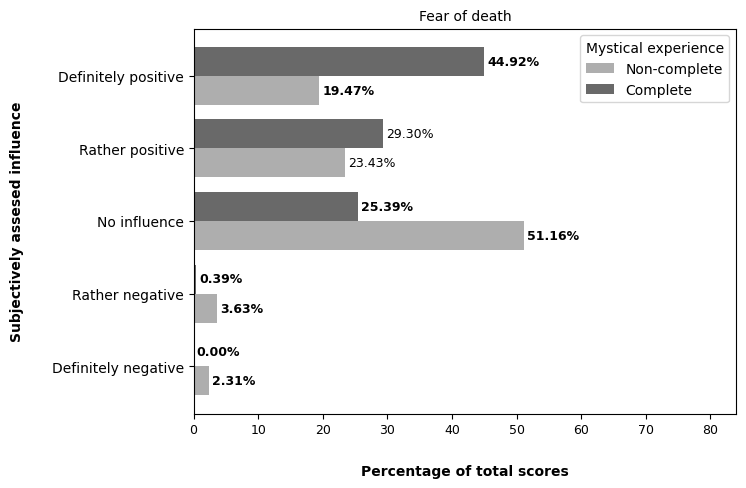

In [399]:
fisher_results_df["p-value"] = pd.to_numeric(fisher_results_df["p-value"])
significant_categories = fisher_results_df[fisher_results_df["p-value"] < 0.05]["Category"].tolist()

df_percentages = pd.DataFrame({
    "Non-complete": non_complete_percentages,
    "Complete": complete_percentages
})

fig, ax = plt.subplots(figsize=(7, 5))
bars = df_percentages.plot(kind="barh", ax=ax, width=0.8, color=["#AEAEAE", "#696969"])

for container in bars.containers:
    for bar in container:
        category = df_percentages.index[container.index(bar)]
        label = f"{bar.get_width():.2f}%"
        label_style = {"fontweight": "bold"} if category in significant_categories else {"fontweight": "normal"}
        ax.text(
            bar.get_width() + 0.5,
            bar.get_y() + bar.get_height() / 2,
            label,
            fontweight=label_style["fontweight"],
            fontsize=9,
            va="center"
        )

plt.title("Fear of death", fontsize=10)
plt.xlabel("Percentage of total scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Subjectively assesed influence", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=10)
plt.xticks(fontsize=9)
plt.xlim(0, 84)

plt.show()

### **5.4.2. Empathy**

In [235]:
complete_counts = (filtered_df_complete["influence_empathy"].value_counts()).reindex(index, fill_value=0)
non_complete_counts = (filtered_df_non_complete["influence_empathy"].value_counts().reindex(index, fill_value=0))

total_complete = complete_counts.sum()
total_non_complete = non_complete_counts.sum()

complete_percentages = ((complete_counts / total_complete) * 100).reindex(index, fill_value=0)
non_complete_percentages = ((non_complete_counts / total_non_complete) * 100).reindex(index, fill_value=0)

In [236]:
fisher_results = []

for category in index:
    observed = [
        [
            complete_counts[category], 
            non_complete_counts[category]
        ],
        [
            total_complete - complete_counts[category],
            total_non_complete - non_complete_counts[category]
        ]
    ]
    
    oddsratio, p_value = fisher_exact(observed)
    
    fisher_results.append({
        "Category": category,
        "Odds ratio": f"{oddsratio:.2f}",
        "p-value": f"{p_value:.3f}"
    })

fisher_results_df = pd.DataFrame(fisher_results)

fisher_results_df

,Category,Odds ratio,p-value
0,Definitely negative,0.00,1.000
1,Rather negative,1.18,1.000
2,No influence,0.24,0.000
3,Rather positive,1.60,0.008
4,Definitely positive,2.44,0.000


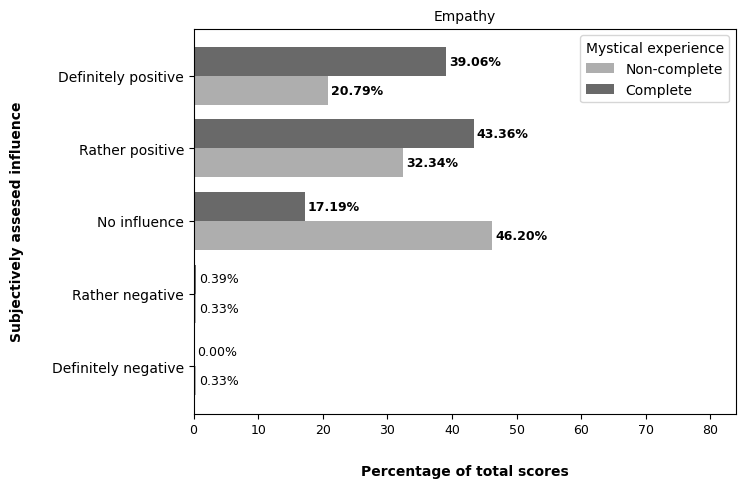

In [237]:
fisher_results_df["p-value"] = pd.to_numeric(fisher_results_df["p-value"])
significant_categories = fisher_results_df[fisher_results_df["p-value"] < 0.05]["Category"].tolist()

df_percentages = pd.DataFrame({
    "Non-complete": non_complete_percentages,
    "Complete": complete_percentages
})

fig, ax = plt.subplots(figsize=(7, 5))
bars = df_percentages.plot(kind="barh", ax=ax, width=0.8, color=["#AEAEAE", "#696969"])

for container in bars.containers:
    for bar in container:
        category = df_percentages.index[container.index(bar)]
        label = f"{bar.get_width():.2f}%"
        label_style = {"fontweight": "bold"} if category in significant_categories else {"fontweight": "normal"}
        ax.text(
            bar.get_width() + 0.5,
            bar.get_y() + bar.get_height() / 2,
            label,
            fontweight=label_style["fontweight"],
            fontsize=9,
            va="center"
        )
    
plt.title("Empathy", fontsize=10)
plt.xlabel("Percentage of total scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Subjectively assesed influence", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=10)
plt.xticks(fontsize=9)
plt.xlim(0, 84)

plt.show()

### **5.4.2. Life satisfaction**

In [238]:
complete_counts = (filtered_df_complete["influence_satisfaction"].value_counts()).reindex(index, fill_value=0)
non_complete_counts = (filtered_df_non_complete["influence_satisfaction"].value_counts().reindex(index, fill_value=0))

total_complete = complete_counts.sum()
total_non_complete = non_complete_counts.sum()

complete_percentages = ((complete_counts / total_complete) * 100).reindex(index, fill_value=0)
non_complete_percentages = ((non_complete_counts / total_non_complete) * 100).reindex(index, fill_value=0)

In [239]:
fisher_results = []

for category in index:
    observed = [
        [
            complete_counts[category], 
            non_complete_counts[category]
        ],
        [
            total_complete - complete_counts[category],
            total_non_complete - non_complete_counts[category]
        ]
    ]
    
    oddsratio, p_value = fisher_exact(observed)
    
    fisher_results.append({
        "Category": category,
        "Odds ratio": f"{oddsratio:.2f}",
        "p-value": f"{p_value:.3f}"
    })

fisher_results_df = pd.DataFrame(fisher_results)

fisher_results_df

,Category,Odds ratio,p-value
0,Definitely negative,0.00,0.503
1,Rather negative,0.35,0.157
2,No influence,0.22,0.000
3,Rather positive,1.15,0.438
4,Definitely positive,2.54,0.000


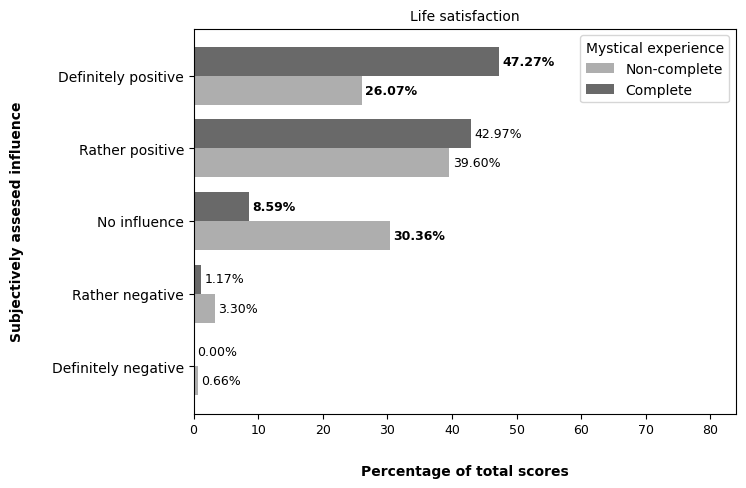

In [240]:
fisher_results_df["p-value"] = pd.to_numeric(fisher_results_df["p-value"])
significant_categories = fisher_results_df[fisher_results_df["p-value"] < 0.05]["Category"].tolist()

df_percentages = pd.DataFrame({
    "Non-complete": non_complete_percentages,
    "Complete": complete_percentages
})

fig, ax = plt.subplots(figsize=(7, 5))
bars = df_percentages.plot(kind="barh", ax=ax, width=0.8, color=["#AEAEAE", "#696969"])

for container in bars.containers:
    for bar in container:
        category = df_percentages.index[container.index(bar)]
        label = f"{bar.get_width():.2f}%"
        label_style = {"fontweight": "bold"} if category in significant_categories else {"fontweight": "normal"}
        ax.text(
            bar.get_width() + 0.5,
            bar.get_y() + bar.get_height() / 2,
            label,
            fontweight=label_style["fontweight"],
            fontsize=9,
            va="center"
        )
    
plt.title("Life satisfaction", fontsize=10)
plt.xlabel("Percentage of total scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Subjectively assesed influence", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=10)
plt.xticks(fontsize=9)
plt.xlim(0, 84)

plt.show()

# **6. Conclusions**